In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from transformers import ViTModel, ViTConfig
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation (Potato Disease Dataset)
data_dir = "/content/drive/MyDrive/School/City College/Spring 2025/CSC 59866/Paper Reproduction/archive/PLD_3_Classes_256/Training"
classes = ["Early_Blight", "Late_Blight", "Healthy"]

# Transforms and Data Loaders
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                      # Resize to 224x224
    #transforms.RandomHorizontalFlip(p=0.5),             # Horizontal flip
    #transforms.RandomVerticalFlip(p=0.5),               # Vertical flip
    #transforms.RandomRotation(degrees=30),              # 30° rotation
    #transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Zoom & scaling
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Standard nomrialization stats for ImageNet.
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=f"{data_dir}", transform=train_transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}", transform=val_transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}", transform=val_transform)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [10]:
# Hybrid Model Definition
class HybridViTCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # CNN with 3x3 kernel
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=1),
            nn.BatchNorm2d(3),
            nn.ReLU()
        )
         # ViT with 6 blocks and 4 heads
        config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
        config.num_hidden_layers = 6
        config.num_attention_heads = 4
        self.vit = ViTModel(config)
        # Classifier
        self.mlp = nn.Sequential(
            nn.Linear(768, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        outputs = self.vit(x)
        x = outputs.last_hidden_state.mean(dim=1)
        return self.mlp(x)

model = HybridViTCNN().to(device)

In [11]:
# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Training Loop
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss, total_correct = 0, 0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
    return total_loss / len(dataloader), total_correct / len(dataloader.dataset)

def validate(model, dataloader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
    return total_loss / len(dataloader), total_correct / len(dataloader.dataset)

# Train for 50 epochs
epochs = 50
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.2%} | Val Acc: {val_acc:.2%}")

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 1/50
Train Loss: 1.0112 | Val Loss: 0.9407
Train Acc: 49.62% | Val Acc: 48.72%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 2/50
Train Loss: 0.8499 | Val Loss: 0.7514
Train Acc: 63.76% | Val Acc: 69.36%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 3/50
Train Loss: 0.7735 | Val Loss: 0.7202
Train Acc: 66.29% | Val Acc: 68.19%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 4/50
Train Loss: 0.6563 | Val Loss: 0.4920
Train Acc: 72.78% | Val Acc: 80.65%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 5/50
Train Loss: 0.5057 | Val Loss: 0.3679
Train Acc: 80.53% | Val Acc: 86.43%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 6/50
Train Loss: 0.4568 | Val Loss: 0.3679
Train Acc: 82.01% | Val Acc: 86.74%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 7/50
Train Loss: 0.3536 | Val Loss: 0.2782
Train Acc: 86.96% | Val Acc: 90.99%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 8/50
Train Loss: 0.3351 | Val Loss: 0.2612
Train Acc: 87.76% | Val Acc: 90.93%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 9/50
Train Loss: 0.2883 | Val Loss: 0.2134
Train Acc: 89.30% | Val Acc: 92.31%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 10/50
Train Loss: 0.2549 | Val Loss: 0.2198
Train Acc: 91.26% | Val Acc: 92.62%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 11/50
Train Loss: 0.2398 | Val Loss: 0.1866
Train Acc: 91.02% | Val Acc: 93.88%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 12/50
Train Loss: 0.2326 | Val Loss: 0.1921
Train Acc: 91.14% | Val Acc: 93.42%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 13/50
Train Loss: 0.2063 | Val Loss: 0.1950
Train Acc: 92.34% | Val Acc: 93.08%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 14/50
Train Loss: 0.1935 | Val Loss: 0.1192
Train Acc: 93.36% | Val Acc: 96.16%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 15/50
Train Loss: 0.1749 | Val Loss: 0.0947
Train Acc: 93.91% | Val Acc: 97.26%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 16/50
Train Loss: 0.1674 | Val Loss: 0.1266
Train Acc: 94.00% | Val Acc: 95.69%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 17/50
Train Loss: 0.1645 | Val Loss: 0.0791
Train Acc: 94.37% | Val Acc: 97.60%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 18/50
Train Loss: 0.1523 | Val Loss: 0.1126
Train Acc: 94.65% | Val Acc: 96.52%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 19/50
Train Loss: 0.1303 | Val Loss: 0.0964
Train Acc: 95.79% | Val Acc: 96.34%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 20/50
Train Loss: 0.1163 | Val Loss: 0.1151
Train Acc: 95.97% | Val Acc: 95.94%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 21/50
Train Loss: 0.1458 | Val Loss: 0.0711
Train Acc: 95.02% | Val Acc: 97.88%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 22/50
Train Loss: 0.1381 | Val Loss: 0.1137
Train Acc: 95.08% | Val Acc: 96.19%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 23/50
Train Loss: 0.1259 | Val Loss: 0.0936
Train Acc: 95.82% | Val Acc: 96.92%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 24/50
Train Loss: 0.1143 | Val Loss: 0.0709
Train Acc: 95.85% | Val Acc: 97.79%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 25/50
Train Loss: 0.1177 | Val Loss: 0.0784
Train Acc: 96.06% | Val Acc: 97.26%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 26/50
Train Loss: 0.1273 | Val Loss: 0.0502
Train Acc: 95.60% | Val Acc: 98.49%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 27/50
Train Loss: 0.0902 | Val Loss: 0.0687
Train Acc: 96.89% | Val Acc: 97.63%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 28/50
Train Loss: 0.1009 | Val Loss: 0.0706
Train Acc: 96.09% | Val Acc: 97.51%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 29/50
Train Loss: 0.0795 | Val Loss: 0.0716
Train Acc: 97.23% | Val Acc: 97.75%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 30/50
Train Loss: 0.0997 | Val Loss: 0.0560
Train Acc: 96.37% | Val Acc: 98.19%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 31/50
Train Loss: 0.0747 | Val Loss: 0.0348
Train Acc: 97.45% | Val Acc: 98.80%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 32/50
Train Loss: 0.0679 | Val Loss: 0.0546
Train Acc: 97.97% | Val Acc: 98.37%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 33/50
Train Loss: 0.0717 | Val Loss: 0.0468
Train Acc: 97.51% | Val Acc: 98.31%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 34/50
Train Loss: 0.0757 | Val Loss: 0.0574
Train Acc: 97.51% | Val Acc: 98.12%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 35/50
Train Loss: 0.0827 | Val Loss: 0.0534
Train Acc: 97.39% | Val Acc: 98.06%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 36/50
Train Loss: 0.0495 | Val Loss: 0.0201
Train Acc: 98.28% | Val Acc: 99.51%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 37/50
Train Loss: 0.0744 | Val Loss: 0.0566
Train Acc: 97.51% | Val Acc: 98.19%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 38/50
Train Loss: 0.0829 | Val Loss: 0.0290
Train Acc: 97.02% | Val Acc: 99.14%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 39/50
Train Loss: 0.0499 | Val Loss: 0.0483
Train Acc: 98.12% | Val Acc: 98.43%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 40/50
Train Loss: 0.0779 | Val Loss: 0.0257
Train Acc: 97.45% | Val Acc: 99.23%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 41/50
Train Loss: 0.0605 | Val Loss: 0.0131
Train Acc: 97.88% | Val Acc: 99.72%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

In [2]:
# Evaluation
def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

y_true, y_pred = evaluate(model, test_loader)
print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("F1-Score:", f1_score(y_true, y_pred, average='macro'))
print(classification_report(y_true, y_pred, target_names=classes))

NameError: name 'model' is not defined

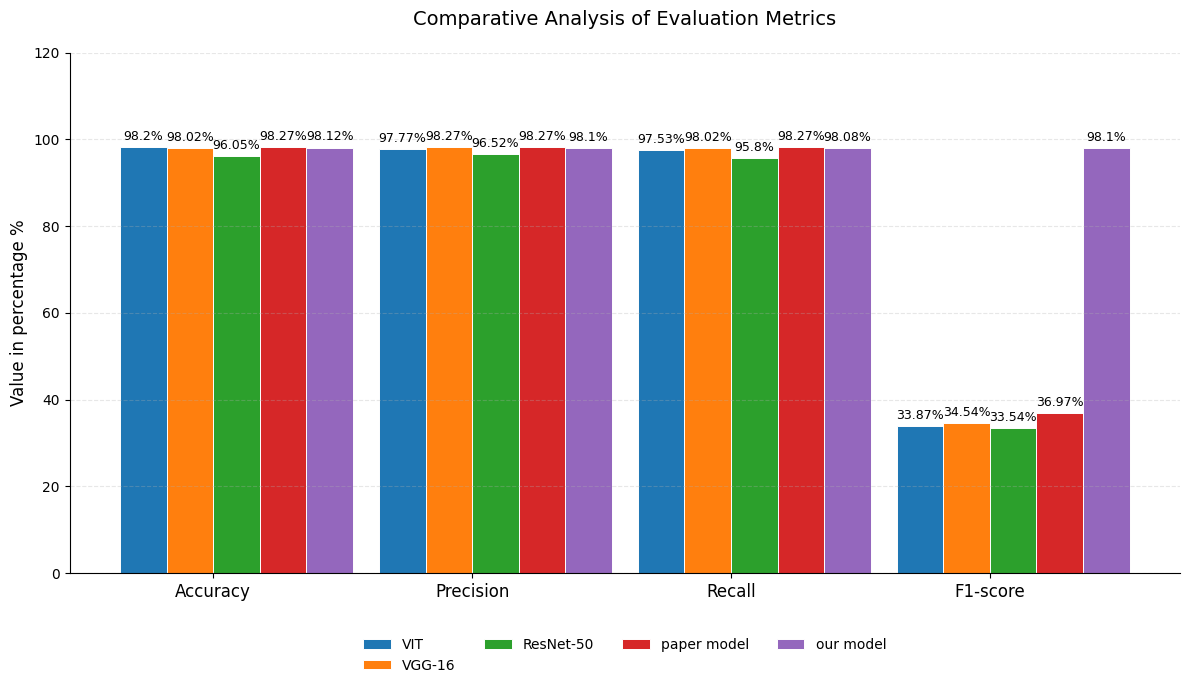

In [3]:
# Plot Results
%matplotlib inline

models = ['Accuracy', 'Precision', 'Recall', 'F1-score']
metrics = {
    'VIT': [98.2, 97.77, 97.53, 33.87],
    'VGG-16': [98.02, 98.27, 98.02, 34.54],
    'ResNet-50': [96.05, 96.52, 95.80, 33.54],
    'paper model': [98.27, 98.27, 98.27, 36.97],
    'our model': [98.12, 98.10, 98.08, 98.10]
}

x = np.arange(len(models))
width = 0.18

fig, ax = plt.subplots(figsize=(12, 7))

for i, (metric, values) in enumerate(metrics.items()):
    offset = width * i
    bars = ax.bar(x + offset, values, width, label=metric,
                 edgecolor='white', linewidth=0.7)

    ax.bar_label(bars, labels=[f"{v}%" for v in values],
                padding=3, fontsize=9)

ax.set_ylabel('Value in percentage %', fontsize=12)
ax.set_title('Comparative Analysis of Evaluation Metrics',
            fontsize=14, pad=20)
ax.set_xticks(x + width*1.5)
ax.set_xticklabels(models, fontsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          ncol=4, framealpha=0)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 120)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

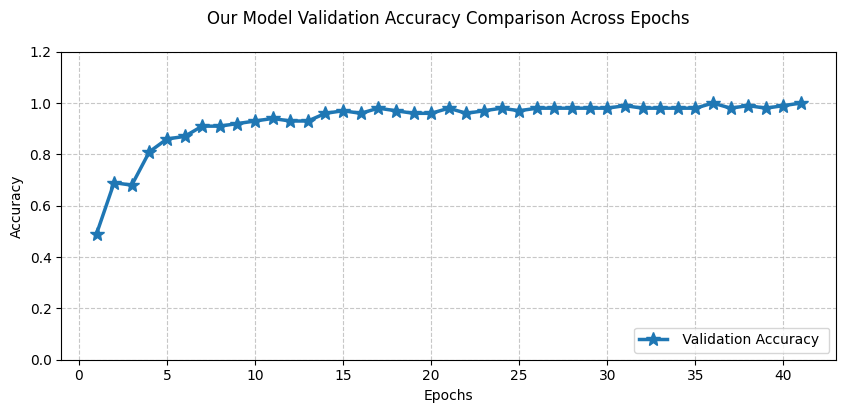

In [29]:
epochs = np.arange(1, 42)
val_acc = [
    0.49, 0.69, 0.68, 0.81, 0.86, 0.87, 0.91, 0.91, 0.92, 0.93,
    0.94, 0.93, 0.93, 0.96, 0.97, 0.96, 0.98, 0.97, 0.96, 0.96,
    0.98, 0.96, 0.97, 0.98, 0.97, 0.98, 0.98, 0.98, 0.98, 0.98,
    0.99, 0.98, 0.98, 0.98, 0.98, 1.00, 0.98, 0.99, 0.98, 0.99,
    1.00
]

plt.figure(figsize=(10, 4))

plt.plot(epochs, val_acc, marker='*', markersize=10, label=' Validation Accuracy ', linewidth=2.5)

plt.title('Our Model Validation Accuracy Comparison Across Epochs', pad=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')

plt.ylim(0, 1.2)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

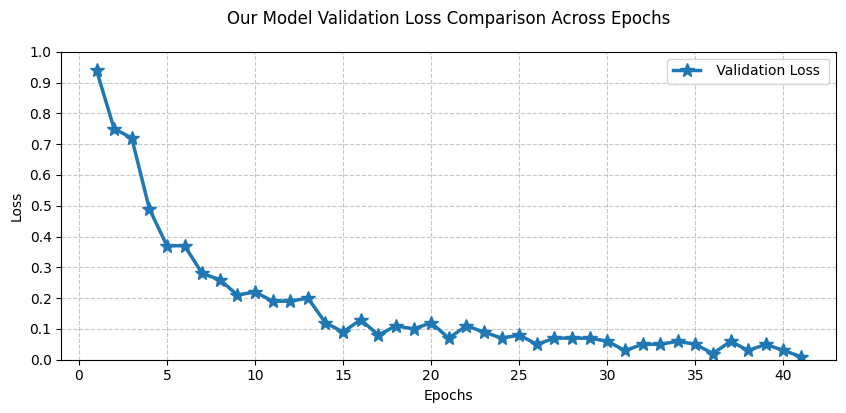

In [31]:
epochs = np.arange(1, 42)
val_loss = [
    0.94, 0.75, 0.72, 0.49, 0.37, 0.37, 0.28, 0.26, 0.21, 0.22,
    0.19, 0.19, 0.20, 0.12, 0.09, 0.13, 0.08, 0.11, 0.10, 0.12,
    0.07, 0.11, 0.09, 0.07, 0.08, 0.05, 0.07, 0.07, 0.07, 0.06,
    0.03, 0.05, 0.05, 0.06, 0.05, 0.02, 0.06, 0.03, 0.05, 0.03,
    0.01
]

plt.figure(figsize=(10, 4))

plt.plot(epochs, val_loss, marker='*', markersize=10, label=' Validation Loss ', linewidth=2.5)

plt.title('Our Model Validation Loss Comparison Across Epochs', pad=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='upper right')

plt.ylim(0, 1.0)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()